In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from aparent.losses.aparent_losses import *

from visualization.seqprop_visualization import *
from generator.seqprop_generator import *
from predictor.seqprop_predictor import *
from predictor.definitions.aparent_large_all_libs import load_saved_predictor
from optimizer.seqprop_optimizer import *


Using TensorFlow backend.


In [2]:

#Define target isoform loss function
def get_isoform_loss(target_isoform_use, target_bits=1.8, isoform_start=80, isoform_end=115, punish_up_aruns=False, punish_dn_gruns=False, punish_up_c=False, punish_dn_cse=False, punish_dn_aruns=False) :
    
    target_iso = np.zeros((1, 1, 1))
    target_iso[:, :, 0] = target_isoform_use
    
    target_entropy_mse = get_target_entropy_mse(pwm_start=25, pwm_end=125, target_bits=target_bits)
    
    punish_up_c_func = get_punish_c(pwm_start=25, pwm_end=68)
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=125)
    punish_dn_aa_func = get_punish_aa(pwm_start=76, pwm_end=125)
    
    punish_up_aa_func = get_punish_aa(pwm_start=25, pwm_end=68)
    punish_dn_gg_func = get_punish_gg(pwm_start=76, pwm_end=125)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, _, cut_pred, iso_score_pred, cut_score_pred = predictor_outputs

        #Aggregate total predicted isoform abundance
        iso_pred = K.expand_dims(K.sum(cut_pred[..., isoform_start:isoform_end], axis=-1), axis=-1)
        
        #Create target cut constant
        iso_true = K.tile(K.constant(target_iso), (K.shape(sampled_pwm)[0], K.shape(sampled_pwm)[1], 1))

        #Specify costs
        #iso_loss = 1.0 * K.mean(symmetric_sigmoid_kl_divergence(iso_true, iso_pred), axis=0)
        iso_loss = 1.0 * K.mean(sigmoid_kl_divergence(iso_true, iso_pred), axis=0)
        seq_loss = 0.0
        
        if punish_up_c :
            seq_loss += 0.0015 * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        
        if punish_up_aruns :
            seq_loss += 0.0015 * K.mean(punish_up_aa_func(sampled_pwm), axis=0)
        
        if punish_dn_gruns :
            seq_loss += 0.0015 * K.mean(punish_dn_gg_func(sampled_pwm), axis=0)
        
        if punish_dn_cse :
            seq_loss += 1.0 * K.mean(punish_dn_cse_func(sampled_pwm), axis=0)
        
        if punish_dn_aruns :
            seq_loss += 0.0015 * K.mean(punish_dn_aa_func(sampled_pwm), axis=0)
        
        entropy_loss = 0.10 * target_entropy_mse(pwm) #0.25
        
        #Compute total loss
        total_loss = iso_loss + seq_loss + entropy_loss

        return K.sum(total_loss, axis=0)
    
    return loss_func


#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, loss_funcs, library_context, n_sequences=1, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    optimized_pwms = []
    optimized_cuts = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        loss_func = loss_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=205, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=True)
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=library_context), n_sequences=n_sequences, n_samples=n_samples, eval_mode='pwm')
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.1)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        #Specify callback entities
        callbacks =[
            EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, isoform_start=80, isoform_end=115, pwm_start=70-40, pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=[0])
        ]

        #Fit Loss Model
        train_history = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #Retrieve optimized PWMs and predicted cleavage distributionns
        _, optimized_pwm, _, _, cut_pred, _, _ = seqprop_predictor.predict(x=None, steps=1)
        
        optimized_pwms.append(optimized_pwm)
        optimized_cuts.append(cut_pred)

    return optimized_pwms, optimized_cuts



In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../aparent/saved_models')
model_name = 'aparent_large_all_libs.h5'
model_path = os.path.join(save_dir, model_name)

Running optimization experiment 'Alien2 Isoforms'
Optimizing objective 0...


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/5
500/500 [==============================] - 16s 33ms/step - loss: 0.7512
Epoch 2/5
500/500 [==============================] - 20s 41ms/step - loss: 0.3888
Epoch 3/5
500/500 [==============================] - 23s 47ms/step - loss: 0.3696
Epoch 4/5
500/500 [==============================] - 21s 42ms/step - loss: 0.3650
Epoch 5/5
500/500 [==============================] - 21s 42ms/step - loss: 0.3628


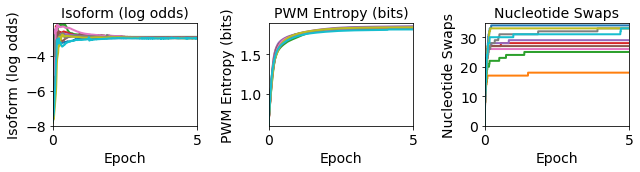

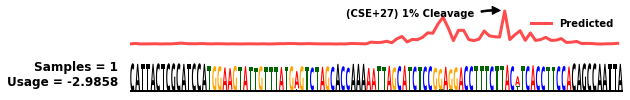

Optimizing objective 1...
Epoch 1/5
500/500 [==============================] - 24s 48ms/step - loss: 2.4191
Epoch 2/5
500/500 [==============================] - 23s 45ms/step - loss: 0.5904
Epoch 3/5
500/500 [==============================] - 25s 50ms/step - loss: 0.4926
Epoch 4/5
500/500 [==============================] - 24s 47ms/step - loss: 0.4749
Epoch 5/5
500/500 [==============================] - 24s 48ms/step - loss: 0.4617


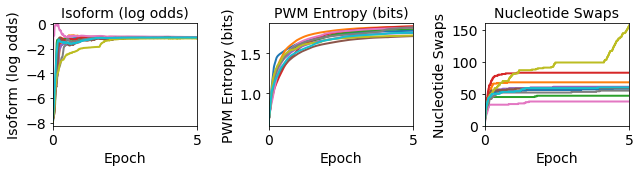

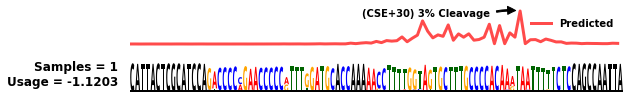

Optimizing objective 2...
Epoch 1/5
500/500 [==============================] - 25s 50ms/step - loss: 2.6283
Epoch 2/5
500/500 [==============================] - 22s 44ms/step - loss: 0.4889
Epoch 3/5
500/500 [==============================] - 27s 53ms/step - loss: 0.4211
Epoch 4/5
500/500 [==============================] - 24s 48ms/step - loss: 0.3960
Epoch 5/5
500/500 [==============================] - 26s 52ms/step - loss: 0.3810


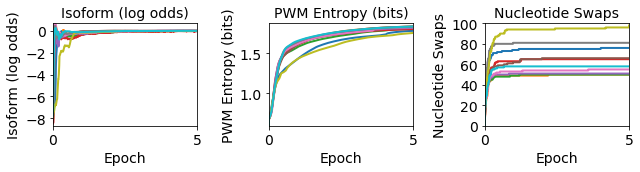

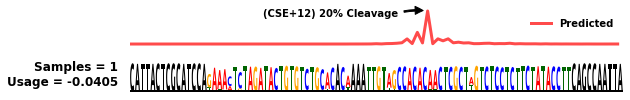

Optimizing objective 3...
Epoch 1/5
500/500 [==============================] - 25s 50ms/step - loss: 4.9140
Epoch 2/5
500/500 [==============================] - 27s 55ms/step - loss: 0.6672
Epoch 3/5
500/500 [==============================] - 22s 44ms/step - loss: 0.5122
Epoch 4/5
500/500 [==============================] - 28s 55ms/step - loss: 0.4573
Epoch 5/5
500/500 [==============================] - 25s 50ms/step - loss: 0.4269


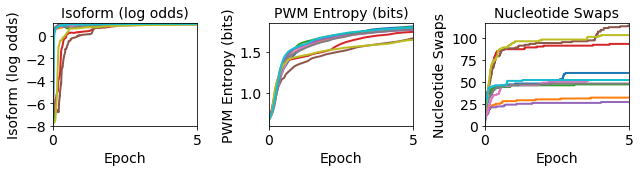

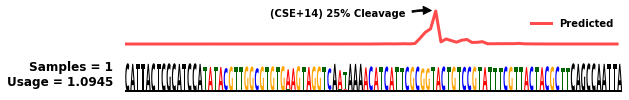

Optimizing objective 4...
Epoch 1/5
500/500 [==============================] - 28s 55ms/step - loss: 4.0958
Epoch 2/5
500/500 [==============================] - 21s 42ms/step - loss: 0.9084
Epoch 3/5
500/500 [==============================] - 20s 40ms/step - loss: 0.7214
Epoch 4/5
500/500 [==============================] - 20s 41ms/step - loss: 0.6579
Epoch 5/5
500/500 [==============================] - 27s 53ms/step - loss: 0.6198


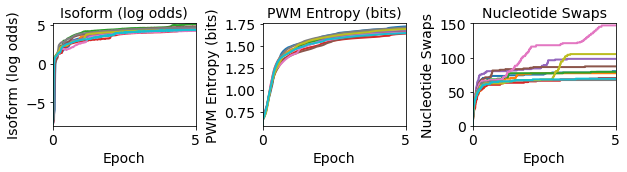

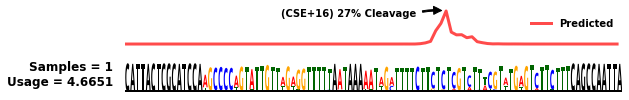

In [4]:
#Optimize target isoform proportions for the 'Alien2' (aka 'Doubledope') library

seq_template = 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXCATTACTCGCATCCANNNNNNNNNNNNNNNNNNNNNNNNNANNAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCAGCCAATTAAGCCTGTCGTCGTGGGTGTCGAAAATGAAATAAAACAAGTCAATTGCGTAGTTTATTCAGACGTACCCCGTGGACCTAC'
library_context = 'doubledope'

iso_objectives = [0.05, 0.25, 0.50, 0.75, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'Alien2 Isoforms'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 5#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses = [
    get_isoform_loss(
        target_iso,
        target_bits=1.8,
        punish_up_aruns=True,
        punish_dn_gruns= True,
        punish_up_c = True,
        punish_dn_aruns = True#False
    )
    for target_iso in iso_objectives
]

alien2_pwms, alien2_cuts = run_seqprop(sequence_templates, losses, library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)



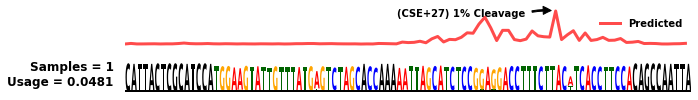

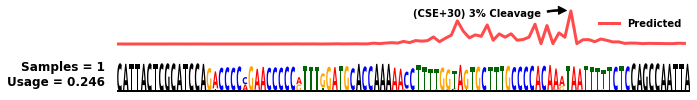

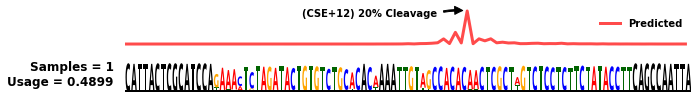

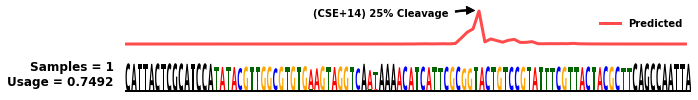

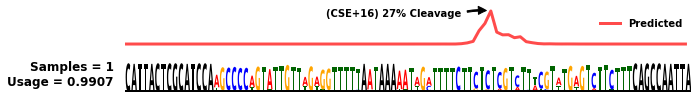

In [5]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Alien2 Isoforms')

pwms = alien2_pwms
cuts = alien2_cuts

pwm_index = 0 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 80:115], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-40, plot_end=76+50)


Running optimization experiment 'TOMM5 Isoforms'
Optimizing objective 0...
Epoch 1/5
500/500 [==============================] - 27s 53ms/step - loss: 0.3974
Epoch 2/5
500/500 [==============================] - 26s 53ms/step - loss: 0.2014
Epoch 3/5
500/500 [==============================] - 18s 37ms/step - loss: 0.1923
Epoch 4/5
500/500 [==============================] - 21s 42ms/step - loss: 0.1856
Epoch 5/5
500/500 [==============================] - 23s 46ms/step - loss: 0.1841


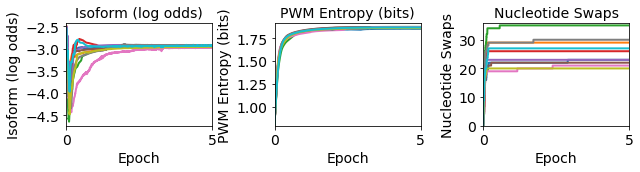

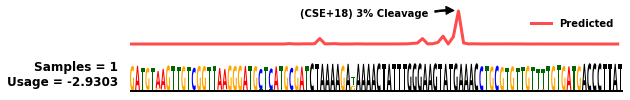

Optimizing objective 1...
Epoch 1/5
500/500 [==============================] - 25s 51ms/step - loss: 0.5074
Epoch 2/5
500/500 [==============================] - 21s 42ms/step - loss: 0.2083
Epoch 3/5
500/500 [==============================] - 21s 43ms/step - loss: 0.1950
Epoch 4/5
500/500 [==============================] - 22s 43ms/step - loss: 0.1920
Epoch 5/5
500/500 [==============================] - 26s 52ms/step - loss: 0.1903


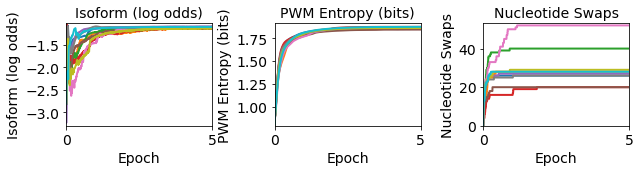

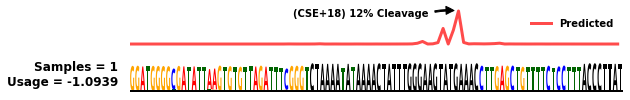

Optimizing objective 2...
Epoch 1/5
500/500 [==============================] - 23s 46ms/step - loss: 0.9414
Epoch 2/5
500/500 [==============================] - 19s 38ms/step - loss: 0.2335
Epoch 3/5
500/500 [==============================] - 24s 47ms/step - loss: 0.1992
Epoch 4/5
500/500 [==============================] - 19s 39ms/step - loss: 0.1887
Epoch 5/5
500/500 [==============================] - 26s 51ms/step - loss: 0.1831


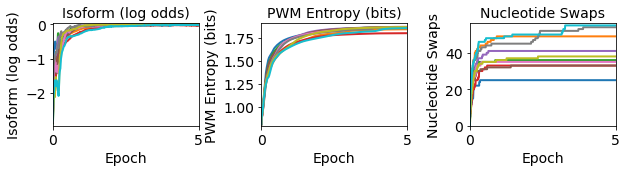

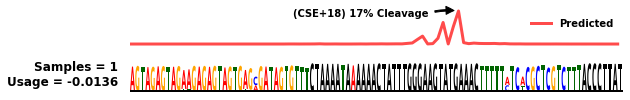

Optimizing objective 3...
Epoch 1/5
500/500 [==============================] - 25s 50ms/step - loss: 2.1896
Epoch 2/5
500/500 [==============================] - 21s 43ms/step - loss: 0.4459
Epoch 3/5
500/500 [==============================] - 19s 38ms/step - loss: 0.3595
Epoch 4/5
500/500 [==============================] - 19s 38ms/step - loss: 0.2404
Epoch 5/5
500/500 [==============================] - 21s 43ms/step - loss: 0.2144


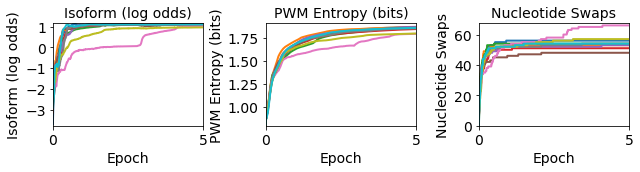

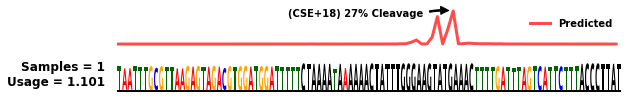

Optimizing objective 4...
Epoch 1/5
500/500 [==============================] - 24s 48ms/step - loss: 5.2505
Epoch 2/5
500/500 [==============================] - 19s 38ms/step - loss: 1.6705
Epoch 3/5
500/500 [==============================] - 25s 51ms/step - loss: 1.3349
Epoch 4/5
500/500 [==============================] - 19s 38ms/step - loss: 1.1927
Epoch 5/5
500/500 [==============================] - 22s 44ms/step - loss: 0.9671


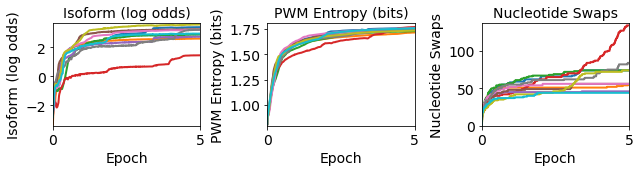

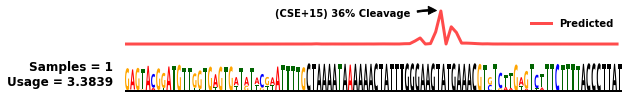

In [6]:
#Optimize target isoform proportions for the 'TOMM5' library

seq_template = 'XXXXXXXXXXXXXXXXXXXXXTGCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNCTAAAANANAAAACTATTTGGGAAGTATGAAACNNNNNNNNNNNNNNNNNNNNACCCTTATCCCTGTGACGTTTGGCCTCTGACAATACTGGTATAATTGTAAATAATGTCAAACTCCGTTTTCTAGCAAGTATTAAGGG'
library_context = 'tomm5_up_c20n20_dn_n20'

iso_objectives = [0.05, 0.25, 0.50, 0.75, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'TOMM5 Isoforms'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 5#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

sequence_templates = [
    seq_template
    for target_iso in iso_objectives
]

losses = [
    get_isoform_loss(
        target_iso,
        target_bits=1.8,
        punish_up_aruns=True,
        punish_dn_gruns= True,
        punish_up_c = True,
        punish_dn_aruns = True#False
    )
    for target_iso in iso_objectives
]

tomm5_pwms, tomm5_cuts = run_seqprop(sequence_templates, losses, library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)



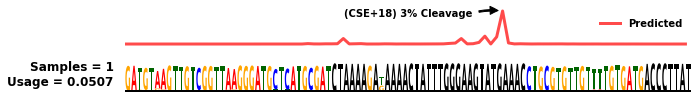

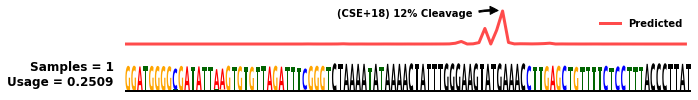

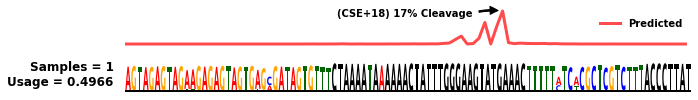

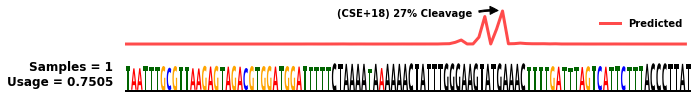

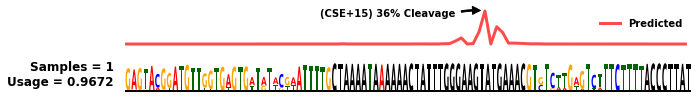

In [7]:
#Plot one PWM sequence logo per optimized objective (Experiment 'TOMM5 Isoforms')

pwms = tomm5_pwms
cuts = tomm5_cuts

pwm_index = 0 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 80:115], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-40, plot_end=76+50)


Running optimization experiment 'Max Isoforms of 6 libraries'
Optimizing objective 0...


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/5
500/500 [==============================] - 17s 35ms/step - loss: 0.9983
Epoch 2/5
500/500 [==============================] - 16s 32ms/step - loss: 0.5732
Epoch 3/5
500/500 [==============================] - 15s 30ms/step - loss: 0.5287
Epoch 4/5
500/500 [==============================] - 15s 30ms/step - loss: 0.5024
Epoch 5/5
500/500 [==============================] - 19s 38ms/step - loss: 0.4873


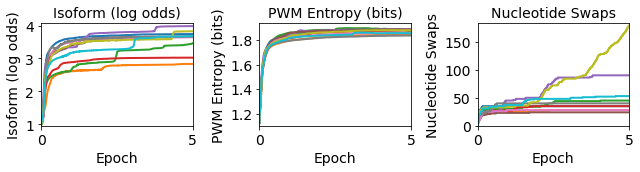

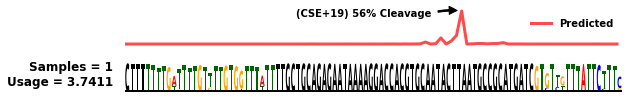

Optimizing objective 0...
Epoch 1/5
500/500 [==============================] - 20s 40ms/step - loss: 4.4259
Epoch 2/5
500/500 [==============================] - 17s 34ms/step - loss: 1.9852
Epoch 3/5
500/500 [==============================] - 21s 43ms/step - loss: 1.6844
Epoch 4/5
500/500 [==============================] - 23s 46ms/step - loss: 1.5646
Epoch 5/5
500/500 [==============================] - 25s 49ms/step - loss: 1.5154


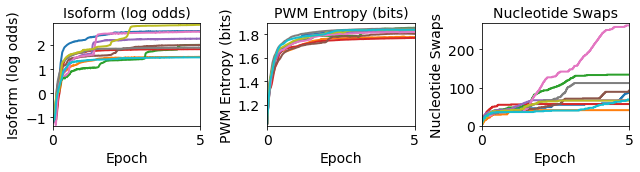

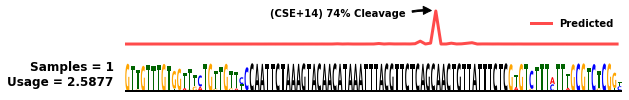

Optimizing objective 0...
Epoch 1/5
500/500 [==============================] - 18s 37ms/step - loss: 1.4935
Epoch 2/5
500/500 [==============================] - 19s 39ms/step - loss: 0.7573
Epoch 3/5
500/500 [==============================] - 15s 30ms/step - loss: 0.6941
Epoch 4/5
500/500 [==============================] - 19s 39ms/step - loss: 0.6602
Epoch 5/5
500/500 [==============================] - 16s 31ms/step - loss: 0.5748


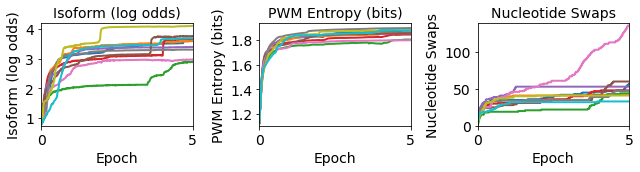

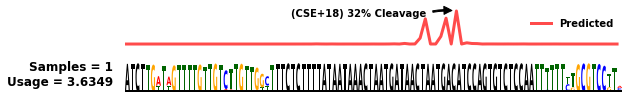

Optimizing objective 0...
Epoch 1/5
500/500 [==============================] - 21s 43ms/step - loss: 0.9604
Epoch 2/5
500/500 [==============================] - 21s 42ms/step - loss: 0.6543
Epoch 3/5
500/500 [==============================] - 16s 32ms/step - loss: 0.6064
Epoch 4/5
500/500 [==============================] - 18s 36ms/step - loss: 0.5881
Epoch 5/5
500/500 [==============================] - 20s 40ms/step - loss: 0.5780


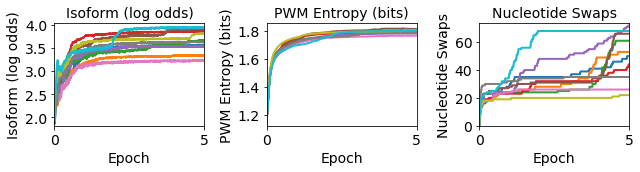

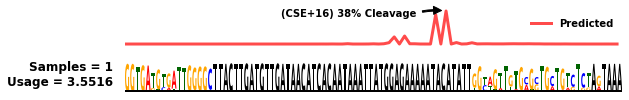

Optimizing objective 0...
Epoch 1/5
500/500 [==============================] - 18s 36ms/step - loss: 5.8319
Epoch 2/5
500/500 [==============================] - 16s 32ms/step - loss: 1.6163
Epoch 3/5
500/500 [==============================] - 17s 34ms/step - loss: 1.3952
Epoch 4/5
500/500 [==============================] - 19s 38ms/step - loss: 1.2058
Epoch 5/5
500/500 [==============================] - 16s 33ms/step - loss: 1.1776


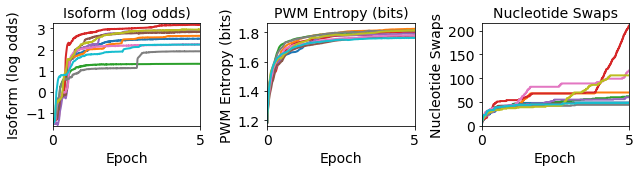

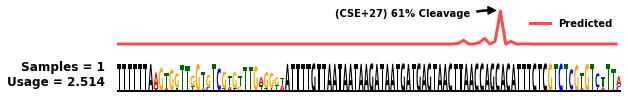

Optimizing objective 0...
Epoch 1/5
500/500 [==============================] - 17s 35ms/step - loss: 0.7266
Epoch 2/5
500/500 [==============================] - 18s 35ms/step - loss: 0.4754
Epoch 3/5
500/500 [==============================] - 17s 35ms/step - loss: 0.4572
Epoch 4/5
500/500 [==============================] - 16s 33ms/step - loss: 0.4458
Epoch 5/5
500/500 [==============================] - 18s 37ms/step - loss: 0.4388


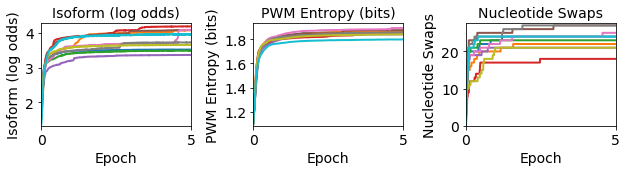

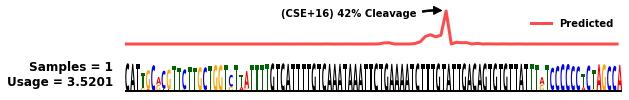

In [7]:
#Maximize isoform proportions for 6 native minigene libraries

seq_templates = [
    'XXXXXXXXXXXXXXXXXXXXXATCTCTGAGCTTTNNNNNNNNNNNNNNNNNNNNNNNNNTTGCTGCAGAGAATAAAAGGACCACGTGCAATACTTAATGCCGCATGATCNNNNNNNNNNNNNNNNNNNNNNNNNGGCTCTTTTGACAGCCTTTGGCGTCTGTAGAATAAATGCTGTGGCTCCTGCTGGCTGCTGTGGTGTTCACC',
    'XXXXXXXXXXXXXXXXXXXXXTGCATTTGNNNNNNNNNNNNNNNNNNNNNNNNNCAATTCTAAAGTACAACATAAATTTACGTTCTCAGCAACTGTTATTTCTCNNNNNNNNNNNNNNNNNNNNNNNNNAATATACATTCAGTTATTAAGAAATAAACTGCTTTCTTAATACATACTGTGCATTATAATTGGAGAAATAGAATAT',
    'XXXXXXXXXXXXXXXXXXXXXTCTTCTGAAATCTNNNNNNNNNNNNNNNNNNNNNNNNNTTCTCTTTTATAATAAACTAATGATAACTAATGACATCCAGTGTCTCCAANNNNNNNNNNNNNNNNNNNNNNNNNCACTTCCAAATAAAAATATGTAAATGAGTGGTTAATCTTTAGTTATTTTAAGATGATTTTAGGGTTTTGCT',
    'XXXXXXXXXXXXXXXXXXXXXANNNNNNNNNNNNNNNNNNNNNNNNNTTACTTGATGTTGATAACATCACAATAAATTATGGAGAAAAATACATATTNNNNNNNNNNNNNNNNNNNNNNNANTAAAGTGTTTTCTTTTAAATCAACTCTAAATAGCTCCATTCTCATAGTCACTAGTCAGACCGCTCGCGCACTACTCAGCGACC',
    'XXXXXXXXXXXXXXXXXXXXXCGATCTTCTTTTTTTANNNNNNNNNNNNNNNNNNNNNNNNNATTTTGTTAATAATAAGATAATGATGAGTAACTTAACCAGCACATTTCTCNNNNNNNNNNNNNNNNNNNNNNNNNGTTTTCTGATGACATAATAAAGACAGATCATTTCAGAATCTGGCCCTTGTGCAGGGGAGGAGGGAGGC',
    'XXXXXXXXXXXXXXXXXXXXXCTTGAATTTCATNNNNNNNNNNNNNNNNNNNNNNNNNGTCATTTTGTCAAATAAATTCTGAAAATCTTTGTATTGACAGTGTGTTATNNNNNNNNNNNNNNNNNNNNNNNNNAGTGCTCAATAAAAAGAATAAAGAGGAAACAGCACTGGATCTATACCTATACAAAACAAGCTACCAGCGCTC'
]

library_contexts = [
    'aar',
    'atr',
    'hsp',
    'snh',
    'sox',
    'wha'
]

iso_objectives = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

#Run SeqProp Optimization

print("Running optimization experiment 'Max Isoforms of 6 libraries'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 5#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

losses = [
    get_isoform_loss(
        target_iso,
        target_bits=1.8,
        punish_up_aruns=True,
        punish_dn_gruns= True,
        punish_up_c = True,
        punish_dn_aruns = True#False
    )
    for target_iso in iso_objectives
]

max_pwms = []
max_cuts = []

for seq_template, library_context, loss in zip(seq_templates, library_contexts, losses) :

    pwm, cut = run_seqprop([seq_template], [loss], library_context, n_sequences, n_samples, n_epochs, steps_per_epoch)

    max_pwms.extend(pwm)
    max_cuts.extend(cut)


Library = aar


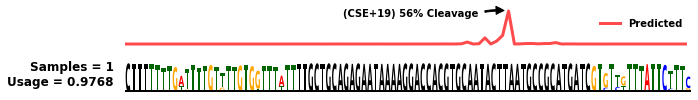

Library = atr


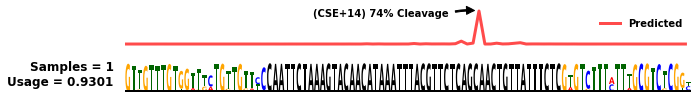

Library = hsp


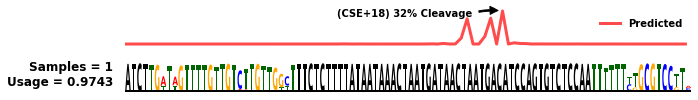

Library = snh


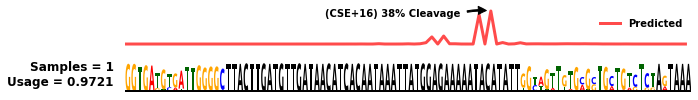

Library = sox


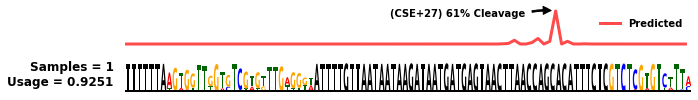

Library = wha


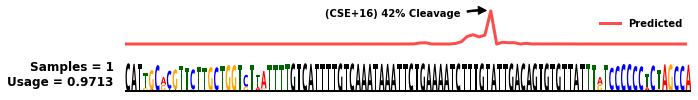

In [9]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Max Isoforms of 6 libraries')

pwms = max_pwms
cuts = max_cuts

pwm_index = 0 #Chosen PWM index
for obj_index, library_context in enumerate(library_contexts) :
    
    print("Library = " + str(library_context))
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, 80:115], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=seq_templates[obj_index], figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='fraction', plot_start=70-40, plot_end=76+50)
